<a href="https://colab.research.google.com/github/Eleemon98/JDF/blob/main/0412_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install filterpy

     ---------------------------------------- 0.0/178.0 kB ? eta -:--:--
     -- ------------------------------------- 10.2/178.0 kB ? eta -:--:--
     -------------------------------------- 178.0/178.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110542 sha256=1e3bb1e1bf8f3cd3db9d0db77a77494aef3912880e3007af36c180799954d82a
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\12\dc\3c\e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import cv2 as cv
import sys

# object detection > Tracking
# YOLOv3 > SORT

# Yolo v3 구조 정의
def construct_yolo_v3():
    # 객체 이름을 로드합니다.
    f = open('coco_names.txt', 'r') # 학습된 데이터 셋
    class_names = [line.strip() for line in f.readlines()]

    # YOLO 모델을 로드합니다.
    model = cv.dnn.readNet('yolov3.weights', 'yolov3.cfg')
    layer_names = model.getLayerNames()
    unconnected_out_layers = model.getUnconnectedOutLayers()
    if len(unconnected_out_layers.shape) == 2:  # 2차원 배열인 경우
        out_layers = [layer_names[i[0] - 1] for i in unconnected_out_layers]
    else:  # 1차원 배열인 경우
        out_layers = [layer_names[i - 1] for i in unconnected_out_layers]

    return model, out_layers, class_names

# Yolo v3를 활용하여 object detection
def yolo_detect(img, yolo_model, out_layers):
    height, width = img.shape[0], img.shape[1]
    test_img = cv.dnn.blobFromImage(img, 1.0 / 256, (448, 448), (0, 0, 0), swapRB=True)

    yolo_model.setInput(test_img)
    output3 = yolo_model.forward(out_layers)

    box, conf, id = [], [], []  # 박스, 신뢰도, 부류 번호
    for output in output3:
        for vec85 in output:
            scores = vec85[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # 신뢰도가 50% 이상인 경우만 취함
                centerx, centery = int(vec85[0] * width), int(vec85[1] * height)
                w, h = int(vec85[2] * width), int(vec85[3] * height)
                x, y = int(centerx - w / 2), int(centery - h / 2)
                box.append([x, y, x + w, y + h])
                conf.append(float(confidence))
                id.append(class_id)

    ind = cv.dnn.NMSBoxes(box, conf, 0.5, 0.4)
    objects = [box[i] + [conf[i]] + [id[i]] for i in range(len(box)) if i in ind]
    return objects

model, out_layers, class_names = construct_yolo_v3()  # YOLO 모델 생성
colors = np.random.uniform(0, 255, size=(100, 3))  # 100개 색으로 트랙 구분

# 동영상에서 사람 추적하기
from sort import Sort
video_path = '39837-424360872_tiny.mp4'
sort = Sort()

cap = cv.VideoCapture(video_path)
# cap = cv.VideoCapture(0, cv.CAP_DSHOW)

if not cap.isOpened():
    sys.exit('동영상을 열 수 없음')

while True:
    ret, frame = cap.read()
    if not ret:
        break
    # 오브젝트 디텍션
    res = yolo_detect(frame, model, out_layers)
    # 사람만 디텍션
    person = [res[i] for i in range(len(res)) if res[i][5] == 0]

    # 추적
    if len(person) == 0:
        tracks = sort.update()
    else:
        tracks = sort.update(np.array(person))

    # 추적한 결과를 시각화
    for i in range(len(tracks)):
        x1, y1, x2, y2, track_id = tracks[i].astype(int)
        cv.rectangle(frame, (x1, y1), (x2, y2), colors[track_id], 2)
        cv.putText(frame, str(track_id), (x1 + 10, y1 + 40), cv.FONT_ITALIC, 3, colors[track_id], 2)

    cv.imshow('test', frame)

    key = cv.waitKey(1)
    if key == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

pip install --user mediapipe
##### opencv를 통해 사용하려면 접근권한이 필요해서 관리자 권한으로 설치해야함
##### anaconda prompt에서 직접 설치해야함(이때는 --user 없어도 됨)

In [ ]:
import mediapipe as mp
import cv2
import sys

# 미디어파이프의 얼굴 검출기 생성
mp_face_detection = mp.solutions.face_detection
# 얼굴에 랜드마크를 그리는 함수
mp_drawing = mp.solutions.drawing_utils

# 얼굴 감지 모델 선택(model_selection = 1 => 정면 얼굴 검출기)
face_detection = mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5)

# 영상 실행
path = '39837-424360872_tiny.mp4'
# cap = cv2.VideoCapture(path)
cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

if not cap.isOpened():
    sys.exit('영상을 열 수 없습니다.')

while True:
    ret, frame=cap.read()
    if not ret:
        print('영상 획득에 실패하였습니다.')
        break

    # 입력받는 이미지를 BGR -> RGB로 변환
    res = face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    if res.detections: # 검출된 얼굴이 있으면,
        for d in res.detections: # 반복해서 얼굴들을 추출하고
            mp_drawing.draw_detection(frame, d) # 추출된 얼굴에 사각형을 그려줌

    cv2.imshow('Face_Detection', frame)

    if cv2.waitKey(5)==ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
import cv2
import mediapipe as mp
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# 감지된 프레임에 마스크를 덧씌우는 함수
# frame: 입력되는 cam 화면
# image: 마스크(오버레이 이미지)
# target_x, target_y: 마스크를 덧씌울 위치값
def mask(frame, image, target_x, target_y):
    overlay_img = cv2.imread(image, cv2.IMREAD_UNCHANGED) # 이미지 불러오기(cv2.IMREAD_UNCHANGED는
    overlay_img = cv2.resize(overlay_img, (300,300), interpolation=cv2.INTER_AREA)

    # 프레임의 크기 지정
    frame_h, frame_w, _ = frame.shape
    over_h, over_w, _ = overlay_img.shape

    # 프레임을 BGRA로 변환(투명도 추가)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2BGRA)

    # 이미지(마스크)를 frame에 덧씌우는 작업
    start_y = max(0, target_y - over_h // 2)
    start_x = max(0, target_x - over_w // 2)
    for i in range(over_h):
        for j in range(over_w):
            if overlay_img[i, j][3] != 0: # 알파값이 0이 아닌 픽셀에 적용
                y = start_y + i
                x = start_x + j
                if y < frame_h and x <frame_w:
                    frame[y, x] = overlay_img[i, j]
    return frame

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # 포즈를 감지하는 함수
    res = pose.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # 랜드마크가 있는지 확인 후
    if res.pose_landmarks:
        # 프레임의 전체 크기
        frame_height, frame_width, _ = frame.shape
        # 얼굴의 코를 감지해서 이미지의 오버레이 위치로 사용
        nose = res.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE]
        nose_x = int(nose.x * frame_width)
        nose_y = int(nose.y * frame_height)

        frame = mask(frame, 'Hulk.png', nose_x, nose_y)

    cv2.imshow('Iron Man', cv2.flip(cv2.cvtColor(frame, cv2.COLOR_BGRA2BGR),1))

    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
import cv2 as cv
import mediapipe as mp

# Mediapipe 손 감지 솔루션 초기화
mp_hand = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils  # 손 랜드마크를 그리기 위한 유틸리티
mp_styles = mp.solutions.drawing_styles  # 손 랜드마크와 연결선의 스타일

# 손 감지 모델 설정
hand = mp_hand.Hands(
    max_num_hands=2,  # 최대 감지 가능한 손의 수
    static_image_mode=False,  # 동영상 입력 모드
    min_detection_confidence=0.5,  # 감지를 위한 최소 신뢰도
    min_tracking_confidence=0.5  # 추적을 위한 최소 신뢰도
)

# 웹캠에서 비디오 캡처 시작
cap = cv.VideoCapture(0, cv.CAP_DSHOW)

while True:
    # 프레임 획득
    ret, frame = cap.read()
    if not ret:
        print('프레임 획득에 실패하여 루프를 나갑니다.')
        break

    # 프레임의 색상 공간을 BGR에서 RGB로 변환 (Mediapipe는 RGB 이미지를 사용)
    res = hand.process(cv.cvtColor(frame, cv.COLOR_BGR2RGB))

    # 감지된 손 랜드마크가 있는 경우
    if res.multi_hand_landmarks:
        for landmarks in res.multi_hand_landmarks:
            # 손 랜드마크 그리기
            mp_drawing.draw_landmarks(
                frame,
                landmarks,
                mp_hand.HAND_CONNECTIONS,  # 손가락 관절 연결선
                mp_styles.get_default_hand_landmarks_style(),  # 랜드마크 스타일
                mp_styles.get_default_hand_connections_style()  # 관절 연결선 스타일
            )

    # 결과 이미지를 좌우반전하여 보여줌 (웹캠은 좌우가 반전되어 보이므로 사용자 친화적인 표시를 위함)
    cv.imshow('MediaPipe Hands', cv.flip(frame, 1))

    # 'q'를 누르면 루프 탈출
    if cv.waitKey(5) == ord('q'):
        break

# 자원 해제
cap.release()
cv.destroyAllWindows()


<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

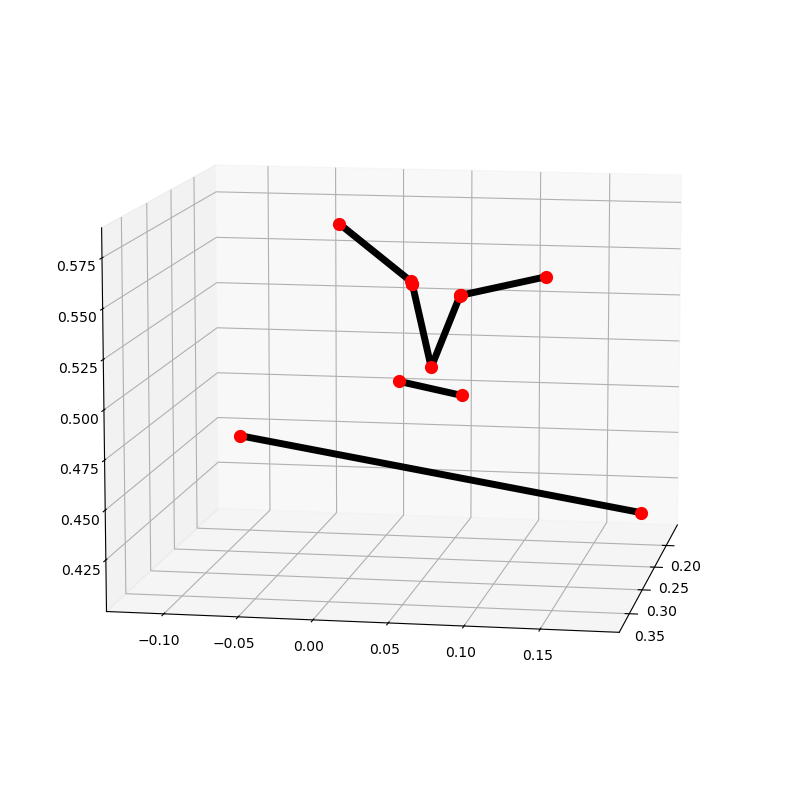

In [ ]:
import cv2 as cv
import mediapipe as mp

# Mediapipe 포즈 모듈과 그리기 유틸리티 초기화
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
mp_styles = mp.solutions.drawing_styles

# 포즈 감지 모델 설정
pose = mp_pose.Pose(
    static_image_mode=False,  # 동적 모드
    enable_segmentation=True,  # 세그멘테이션 활성화 (배경 분리)
    min_detection_confidence=0.5,  # 감지를 위한 최소 신뢰도
    min_tracking_confidence=0.5  # 추적을 위한 최소 신뢰도
)

# 웹캠에서 비디오 캡처 시작
cap = cv.VideoCapture(0, cv.CAP_DSHOW)

while True:
    # 프레임 획득
    ret, frame = cap.read()
    if not ret:
        print('프레임 획득에 실패하여 루프를 나갑니다.')
        break

    # 프레임의 색상 공간을 BGR에서 RGB로 변환 (Mediapipe는 RGB 이미지를 사용)
    res = pose.process(cv.cvtColor(frame, cv.COLOR_BGR2RGB))

    # 감지된 포즈 랜드마크가 있는 경우, 랜드마크와 연결선 그리기
    if res.pose_landmarks:
        mp_drawing.draw_landmarks(
            frame,  # 그릴 이미지
            res.pose_landmarks,  # 포즈 랜드마크
            mp_pose.POSE_CONNECTIONS,  # 랜드마크 연결선
            landmark_drawing_spec=mp_styles.get_default_pose_landmarks_style()  # 랜드마크 스타일
        )

    # 결과 이미지를 좌우반전하여 보여줌 (웹캠은 좌우가 반전되어 보이므로 사용자 친화적인 표시를 위함)
    cv.imshow('MediaPipe pose', cv.flip(frame, 1))

    # 'q'를 누르면 루프 탈출
    if cv.waitKey(5) == ord('q'):
        # 포즈 랜드마크를 플롯 (세계 좌표계에서의 3D 포즈 랜드마크)
        mp_drawing.plot_landmarks(res.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        break

# 자원 해제
cap.release()
cv.destroyAllWindows()